# Clustering Spotify Songs

The dataset contains audio_features data to different type of songs. All songs were extracted using Spotify API. 
features:

Acousticness - The higher the value the more acoustic the song is.	
Danceability - The higher the value, the easier it is to dance to this song.	
Energy - The energy of a song - the higher the value, the more energtic. song	
Instrumentalness - The higher the value the greater likelihood the song contains no vocal.	
Liveness - The higher the value, the more likely the song is a live recording.	
Loudness (dB) - The higher the value, the louder the song.	
Speechiness - The higher the value the more spoken word the song contains.	
Valence - The higher the value, the more positive mood for the song.


The Objective here is to cluster the songs and understand which genres they belong to.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import scipy.cluster.hierarchy as hcd
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

In [3]:
class DataProcessing:
    def __init__(self, file):
        '''creates train and test dataframe'''
        self.df = self._load_data(file)
        
    def _load_data(self, file):
        return pd.read_csv(file)
    
    def dataset_info(self, file):
        '''prints main information'''
        df = self._load_data(file)
        print('\n{0:*^80}'.format(' Reading from the file {0} '.format(file)))
        print("\nit has {0} rows and {1} columns".format(*df.shape))
        print('\n{0:*^80}\n'.format(' It has the following columns '))
        print(df.columns)
        print('\n{0:*^80}\n'.format(' Description of quantitative columns'))
        print(df.describe(include=[np.number]))
        print('\n{0:*^80}\n'.format(' Description of categorical columns'))
        print(df.describe(include=['O']))
        
    def clean_data(self, df, columns_to_drop):
        '''removes columns'''
        df = df.drop(columns_to_drop, axis=1)
        return df
    
    def standard_scaler(self, df):
        # scale df using standard scalar
        scaled = StandardScaler().fit_transform(df)
        df_scaled = pd.DataFrame(scaled, columns=df.columns)
        return df_scaled

In [4]:
class Clustering:
    def k_means(self, df, n_clusters):
        # Predict the cluster
        cluster = KMeans(n_clusters=n_clusters)
        df["cluster"] = cluster.fit_predict(df[df.columns])
        return df
    
    def agglomerative_clustering(self, df, n_clusters, affinity, linkage):
        hc = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
        df['cluster'] = hc.fit_predict(df)
        return df
    
    def density_based_clustering(self, df, eps, metric, min_samples):
        dbscan = DBSCAN(eps=eps, metric=metric, min_samples=min_samples).fit(df)
        labels = dbscan.labels_
        df["cluster"] = dbscan.fit_predict(df)                                                              
        return df

In [5]:
class DimentionReduction:
    def pca_transform(self, df_scaled, n_components):
        # Predict the cluster
        pca = PCA(n_components=n_components)
        pcomponents = pca.fit_transform(df_scaled)
        pca_df = pd.DataFrame(data = pcomponents, columns = ['PC1', 'PC2'])
        ratio = pca.explained_variance_ratio_
        return pca_df, ratio
        
    def tsne_transform(self, df, n_components):
        tsne = TSNE(n_components=n_components).fit_transform(df)
        return tsne

In [29]:
class Visualization:
    def plot_elbow_curve(self, df, num):
        # plot elbow curve to choose number of clusters
        k = range(1, num)
        kmeans = [KMeans(n_clusters=i) for i in k]
        score = [kmeans[i].fit(df[df.columns]).score(df[df.columns]) for i in range(len(kmeans))]
        pl.plot(k, score)
        pl.xlabel('Number of Clusters')
        pl.ylabel('Score')
        pl.title('Elbow Curve')
        pl.show()
        
    def plot_pca(self, pca_df, df, cluster_column):
        sns.set(rc={'figure.figsize': (11.7, 6.27)})
        sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=df[cluster_column], palette='cool_r')
        plt.xlabel('First principle component')
        plt.ylabel('Second principle component')
        plt.show()
        
    def plot_tsne(self, tsne, df, cluster_column):
        sns.set(rc={'figure.figsize': (11.7, 6.27)})
        sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=df[cluster_column], palette="cool_r")
        plt.xlabel('First tsne component')
        plt.ylabel('Second tsne component')
        plt.show()
        
    def plot_dendrogram(self, df, metric, method):
        # plot dendrogram to choose clusters
        plt.style.use('ggplot')
        hcd.set_link_color_palette(["#B061FF", "#7a0177"])
        dendrogram = hcd.dendrogram(hcd.linkage(df, metric=metric, method=method))
        plt.title('Dendrogram', size=20)
        plt.xlabel('Customers', size=15)
        plt.ylabel('Euclidean Distances', size=15)
        plt.show()
        
    def plot_clusters(self, df, cluster):
        sns.set_style("whitegrid")
        bins = np.linspace(0,1,10)
        fig, ax = plt.subplots(1, 5, figsize=(15, 3))
        cluster_df = df[df.cluster == cluster]
        cluster_features = ['acousticness', 'danceability', 'instrumentalness', 'energy', 'speechiness']
        col = 0
        for feature in cluster_features:
            general = df.groupby(pd.cut(df[feature], bins)).size().reset_index(name='count')
            cluster = cluster_df.groupby(pd.cut(cluster_df[feature], bins)).size().reset_index(name='count')
            sns.barplot(data=general, x=feature, y='count', color='#efedf5', ax=ax[col])
            sns.barplot(data=cluster, x=feature, y='count', color='#54278f', ax=ax[col])
            ax[col].set_xticklabels(range(1,10), fontsize=12)
            col += 1
        plt.show()    

In [7]:
file = "./data/songs.csv"

In [8]:
data = DataProcessing(file)
df = data.df
df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.994,0.335,0.00532,0.912,0.0621,-31.646,0.0376,65.832,0.0397
1,0.993,0.343,0.02520,0.932,0.0454,-27.013,0.0488,67.207,0.0395
2,0.994,0.242,0.00898,0.909,0.0814,-31.811,0.0424,68.880,0.0549
3,0.993,0.367,0.01900,0.914,0.0698,-28.121,0.0542,169.443,0.0391
4,0.992,0.295,0.06730,0.868,0.0721,-24.793,0.0362,71.254,0.0801


In [9]:
df.shape

(6171, 9)

In [30]:
clustering = Clustering()
dimention = DimentionReduction()
plot = Visualization()

# KMeans Clustering
## Plot Elbow Curve

Cluster size 3 looks most reasonable

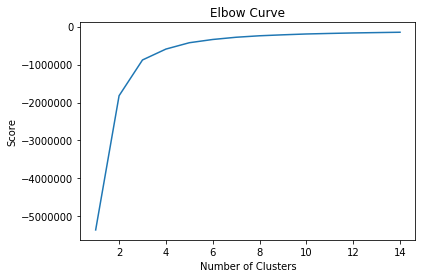

In [11]:
plot.plot_elbow_curve(df, 15)

## Create 3 Clusters

In [13]:
kmeans_df = clustering.k_means(df, 3)

## Visualization using PCA (K-Means)

In [14]:
kmeans_df_scaled = data.standard_scaler(kmeans_df)

In [15]:
kmeans_df_transform, ratio = dimention.pca_transform(kmeans_df_scaled, 2)

In [16]:
# explained_variance_ratio
ratio

array([0.28234163, 0.19503097])

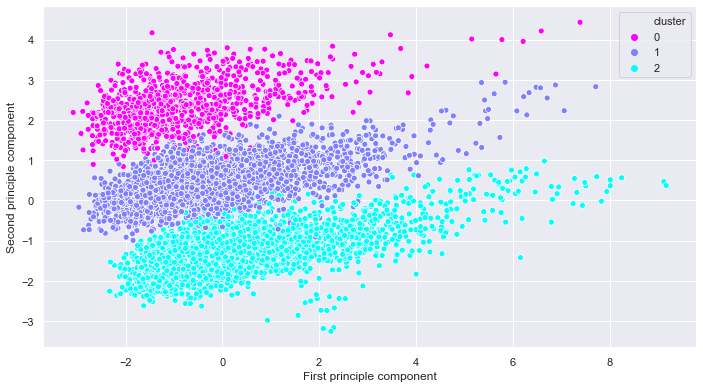

In [17]:
plot.plot_pca(kmeans_df_transform, kmeans_df, 'cluster')

## Visualization using TSNE (K-Means)

In [18]:
kmeans_tsne = dimention.tsne_transform(kmeans_df, 2)

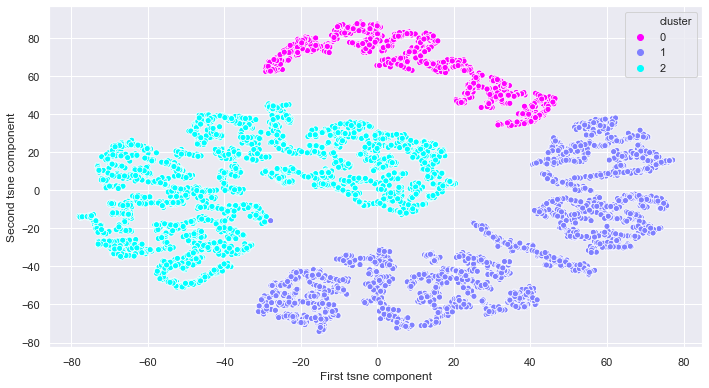

In [19]:
plot.plot_tsne(kmeans_tsne, kmeans_df, 'cluster')

## Visualization segments

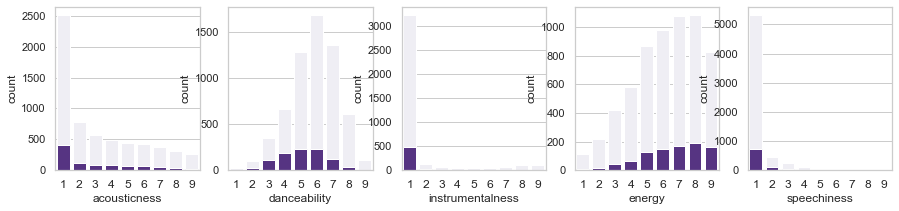

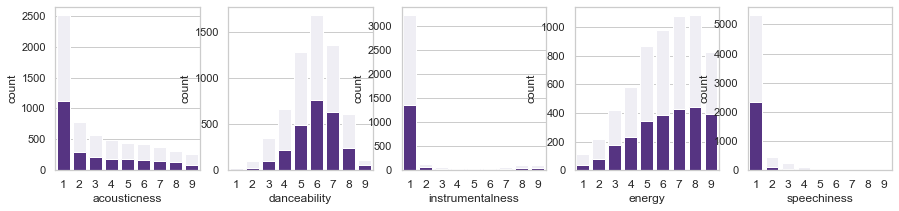

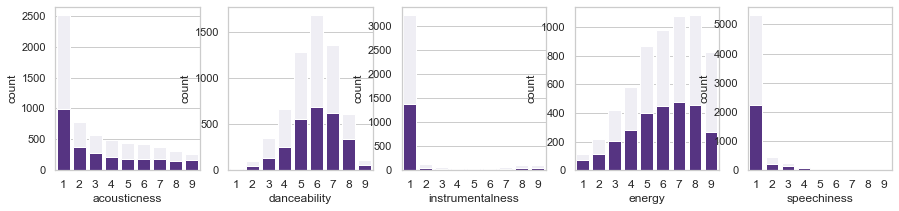

In [20]:
for i in np.sort(kmeans_df['cluster'].unique()):
    plot.plot_clusters(kmeans_df, i)

Cluster 1 all parameters lower values

Cluster 2 hight daceability, energy and low acousticness, speechiness, instrumentalness

Cluster 3 hight daceability, acousticness, energy low instrumentalness, speechiness

# Hierarchical Clustering
## Dendogram - Finding Optimal Number of Clusters

Cluster size 5 looks most reasonable

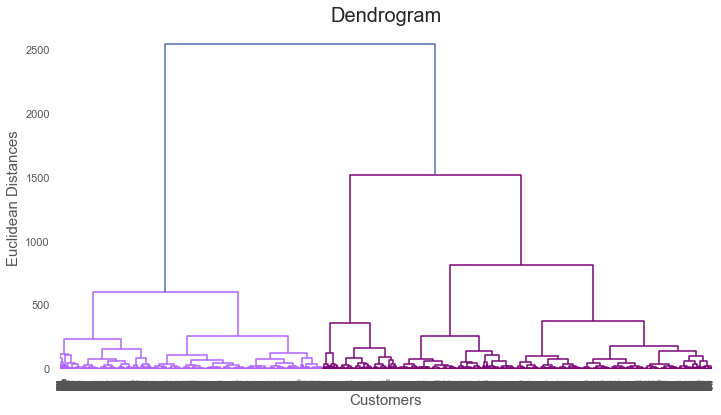

In [21]:
plot.plot_dendrogram(df, 'euclidean', 'ward')

In [40]:
hc_df = clustering.agglomerative_clustering(df, 5, 'euclidean', 'ward')

In [42]:
hc_df.cluster.unique()

array([4, 2, 1, 0, 3])

##  Visualization using PCA (Hierarchical Clustering)

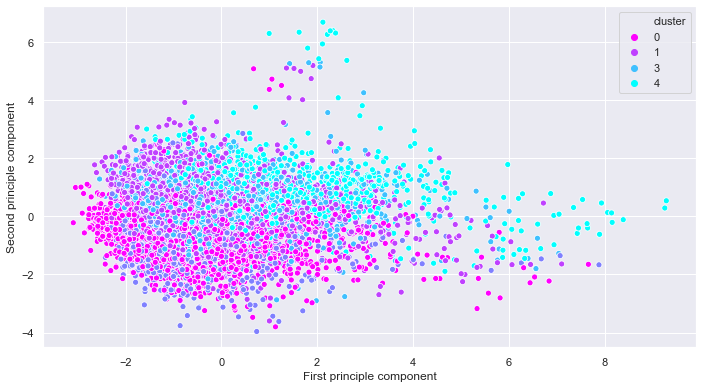

In [44]:
hc_df_scaled = data.standard_scaler(hc_df)
hc_df_transform, ratio = dimention.pca_transform(hc_df_scaled, 2)
plot.plot_pca(hc_df_transform, hc_df, 'cluster')

In [43]:
ratio

array([0.28476507, 0.14336206])

## Visualization using TSNE (Hierarchical Clustering)

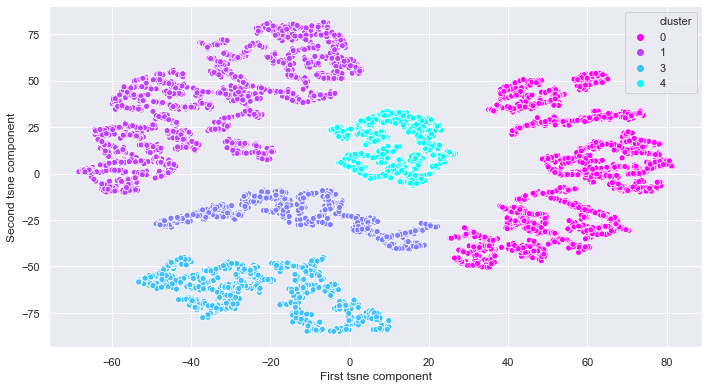

In [45]:
hc_tsne = dimention.tsne_transform(hc_df, 2)
plot.plot_tsne(hc_tsne, hc_df, 'cluster')

## Visualization segments

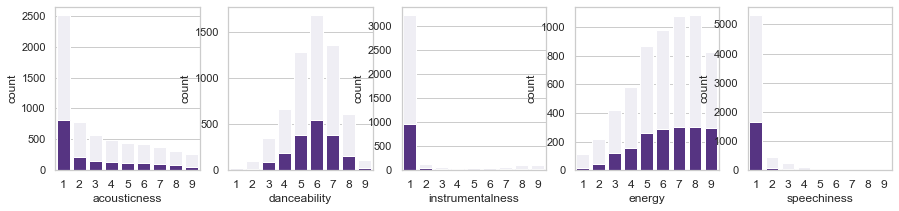

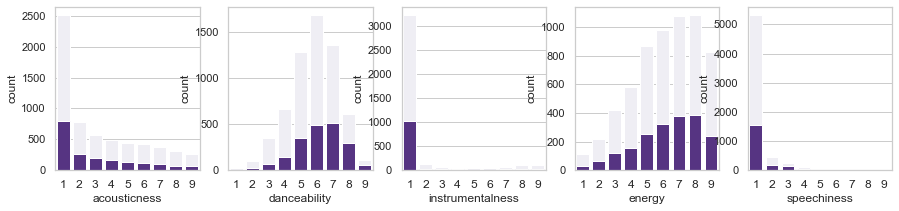

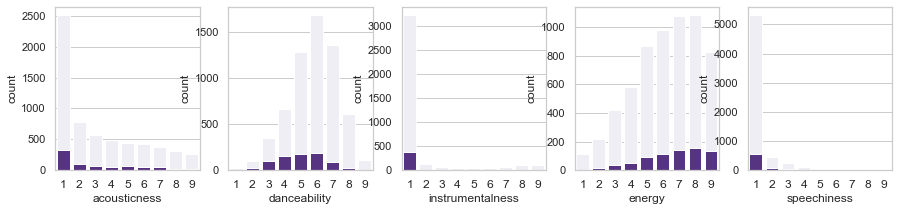

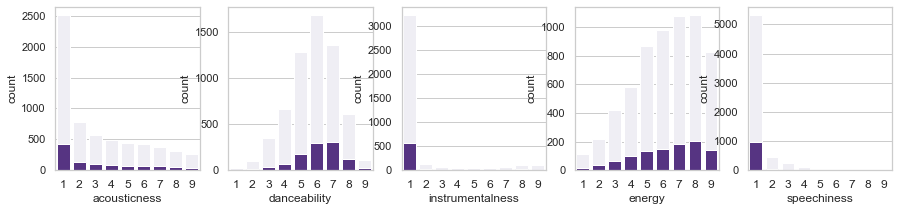

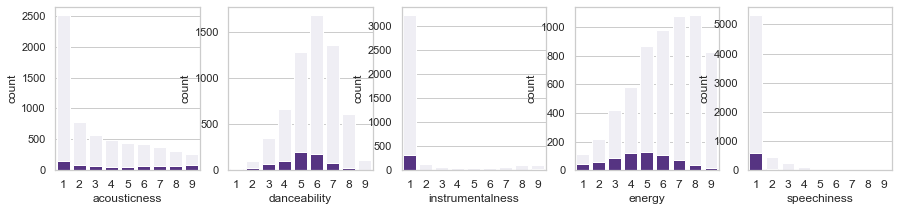

In [46]:
for i in np.sort(hc_df['cluster'].unique()):
    plot.plot_clusters(hc_df, i)

Cluster 1 hight daceability, energy

Cluster 2 hight daceability, energy and low acousticness, speechiness, instrumentalness

Cluster 3 hight energy, low daceability, speechiness, acousticness

Cluster 4 daceability, energy, low instrumentalness, speechiness

Cluster 5 acousticness, low energy, daceability

# DBSCAN

In [34]:
density_df = clustering.density_based_clustering(df, 0.5, 'euclidean', 10)

In [35]:
density_df.cluster.unique()

array([-1,  0,  6,  3,  5,  1,  2,  4])

## Visualization using TSNE (DBSCAN)

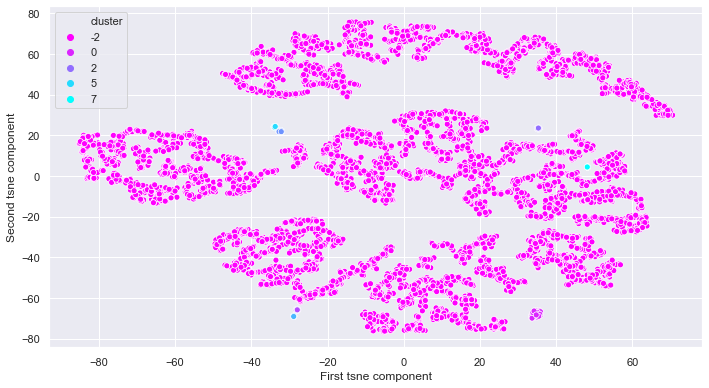

In [36]:
density_tsne = dimention.tsne_transform(density_df, 2)
plot.plot_tsne(density_tsne, density_df, 'cluster')

## Visualization using PCA (DBSCAN)

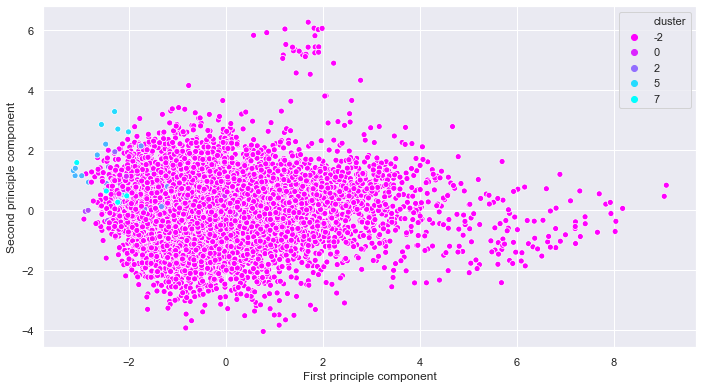

In [37]:
density_df_scaled = data.standard_scaler(density_df)
density_df_transform, ratio = dimention.pca_transform(density_df_scaled, 2)
plot.plot_pca(density_df_transform, density_df, 'cluster')

In [38]:
ratio

array([0.27996244, 0.14047058])

## Visualization segments

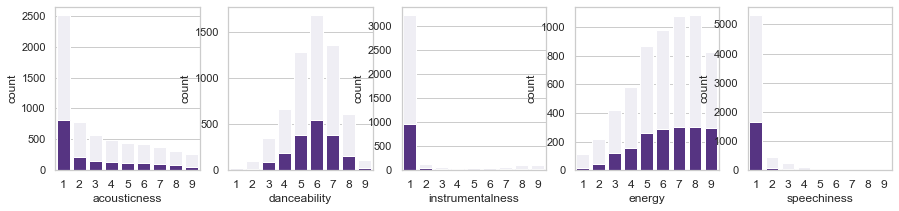

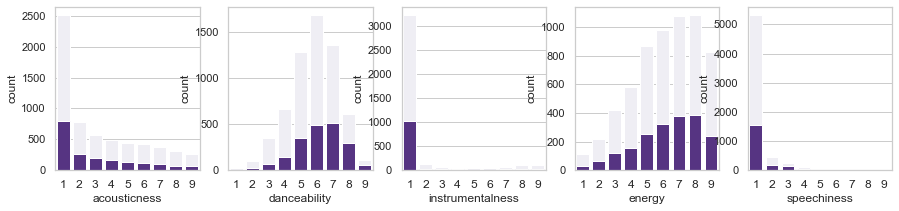

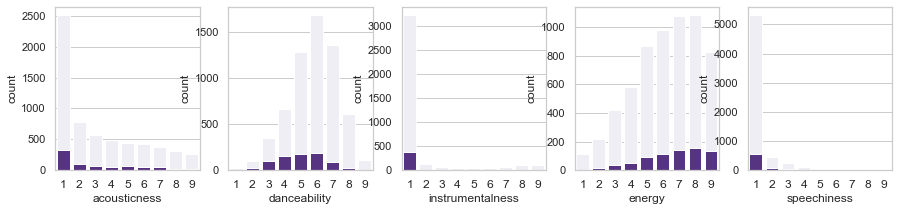

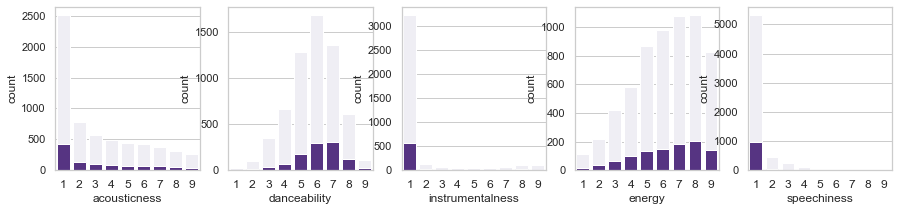

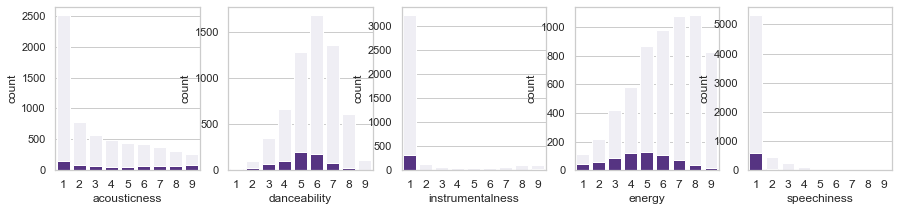

In [47]:
for i in np.sort(density_df['cluster'].unique()):
    plot.plot_clusters(density_df, i)